# %% [markdown]
# # Diabetes Health Indicators Analysis
# ![Diabetes Analysis](https://img.icons8.com/color/96/000000/diabetes.png)
# 
# A comprehensive analysis of diabetes risk factors using CDC's BRFSS survey data with machine learning capabilities.

 ## 1. Import Required Libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from scipy import stats
import plotly.express as px
from ipywidgets import interact, widgets, Layout
from IPython.display import display, Markdown

# Set style for visualizations

plt.style.use('seaborn-v0_8')  # For Matplotlib >= 3.6
# OR
%matplotlib inline

## 2. Data Loading

In [19]:
import os
import pandas as pd

def load_data():
    try:
        # Option 1: Same directory as script
        file_path = 'diabetes_dataset.csv'
        
        # Option 2: Absolute path (replace with your actual path)
        # file_path = r'E:\SEM 4\iDS\project\diabetes_012_health_indicators_BRFSS2015.csv'
        
        # Option 3: Search in parent folders
        # for root, dirs, files in os.walk('..'):
        #     if 'diabetes_012_health_indicators_BRFSS2015.csv' in files:
        #         file_path = os.path.join(root, 'diabetes_012_health_indicators_BRFSS2015.csv')
        
        df = pd.read_csv(file_path)
        print(f"✅ Dataset loaded successfully! Shape: {df.shape}")
        return df
    except Exception as e:
        print(f"❌ Error loading data: {str(e)}")
        return None

df = load_data()
if df is not None:  # Only call .head() if df exists
    print(df.head())

✅ Dataset loaded successfully! Shape: (253680, 22)
   Diabetes_012  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0           0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1           0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2           0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3           0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4           0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0 

## 3. Data Preprocessing

In [ ]:
def preprocess_data(df):
    # Create copy to avoid SettingWithCopyWarning
    processed_df = df.copy()
    
    # Create BMI categories
    processed_df['BMI_Category'] = pd.cut(processed_df['BMI'], 
                                       bins=[0, 18.5, 25, 30, 35, 40, 100],
                                       labels=['Underweight', 'Normal', 'Overweight',
                                              'Obese I', 'Obese II', 'Obese III'])
    
    # Remove outliers using z-score
    numerical_cols = processed_df.select_dtypes(include=[np.number]).columns
    z_scores = np.abs(stats.zscore(processed_df[numerical_cols]))
    processed_df = processed_df[(z_scores < 3).all(axis=1)]
    
    # Prepare features and target
    X = processed_df.drop(['Diabetes_012', 'BMI_Category'], axis=1, errors='ignore')
    y = processed_df['Diabetes_012']
    
    return processed_df, X, y

df_processed, X, y = preprocess_data(df)
print("\nAfter preprocessing:")
print(f"Original shape: {df.shape}")
print(f"Processed shape: {df_processed.shape}")



After preprocessing:
Original shape: (253680, 22)
Processed shape: (170236, 23)


 ## 4. Exploratory Data Analysis

### 4.1 Summary Statistics

In [ ]:
def show_summary(df):
    display(df.describe().T.style.background_gradient(cmap='Blues'))
    
show_summary(df_processed)

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,170236.000000,0.246611,0.645095,0.000000,0.000000,0.000000,0.000000,2.000000
HighBP,170236.000000,0.389477,0.487633,0.000000,0.000000,0.000000,1.000000,1.000000
HighChol,170236.000000,0.395615,0.488984,0.000000,0.000000,0.000000,1.000000,1.000000
CholCheck,170236.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
BMI,170236.000000,27.847036,5.475381,12.000000,24.000000,27.000000,31.000000,48.000000
Smoker,170236.000000,0.393031,0.488425,0.000000,0.000000,0.000000,1.000000,1.000000
Stroke,170236.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
HeartDiseaseorAttack,170236.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PhysActivity,170236.000000,0.792517,0.405505,0.000000,1.000000,1.000000,1.000000,1.000000
Fruits,170236.000000,0.657340,0.474600,0.000000,0.000000,1.000000,1.000000,1.000000


### 4.2 Missing Values Analysis

In [ ]:
def show_missing_values(df):
    missing = df.isnull().sum()
    if missing.sum() == 0:
        print("✅ No missing values found!")
    else:
        print(f"⚠️ Found {missing.sum()} missing values")
        display(missing[missing > 0].to_frame('Missing Count'))
        
show_missing_values(df_processed)

✅ No missing values found!


### 4.3 Feature Distributions

In [25]:
def plot_distribution(column='BMI'):
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(df_processed[column], kde=True, ax=ax)
    ax.set_title(f'Distribution of {column}')
    plt.show()

# Interactive widget
interact(plot_distribution, column=df_processed.select_dtypes(include=np.number).columns);


interactive(children=(Dropdown(description='column', index=4, options=('Diabetes_012', 'HighBP', 'HighChol', '…

### 4.4 Correlation Analysis

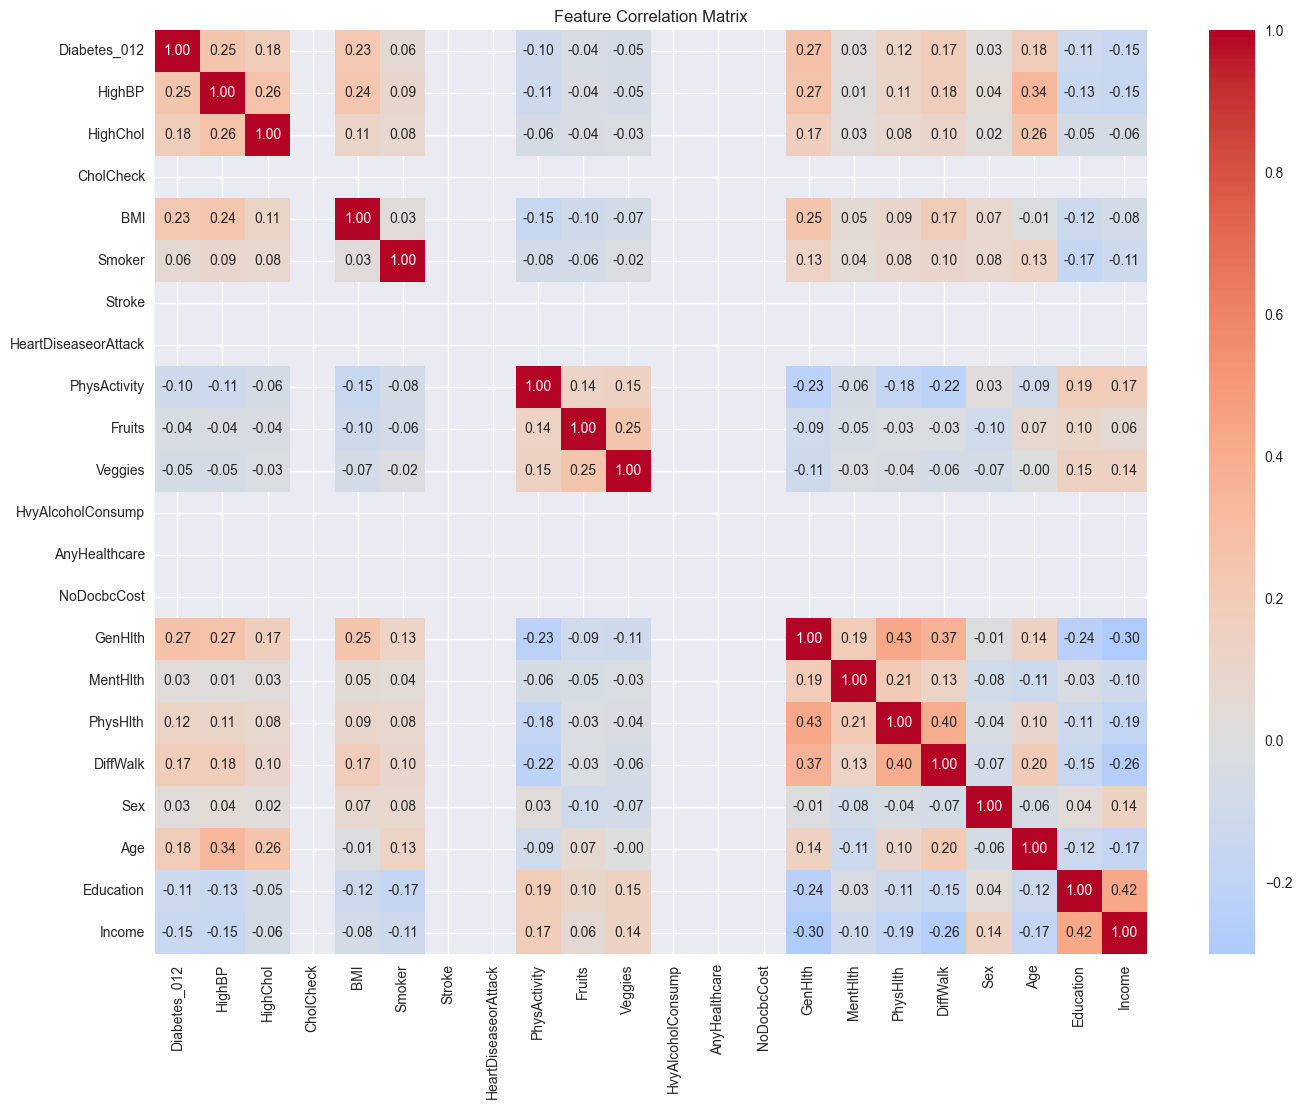

In [27]:
plt.figure(figsize=(16,12))
corr = df_processed.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

 ### 4.5 Grouped Analysis

In [33]:

def show_grouped_analysis(group_col='Age', agg_col='Diabetes_012'):
    # Grouped statistics
    grouped_stats = df_processed.groupby(group_col)[agg_col].agg(['mean', 'median', 'std', 'count'])
    display(grouped_stats.style.background_gradient(cmap='Blues'))
    
    # Visualization
    fig, ax = plt.subplots(figsize=(10, 5))
    if agg_col == 'Diabetes_012':
        sns.barplot(x=group_col, y=agg_col, data=df_processed, ax=ax, ci=None)
    else:
        sns.boxplot(x=group_col, y=agg_col, data=df_processed, ax=ax)
    plt.xticks(rotation=45)
    ax.set_title(f'{agg_col} Distribution by {group_col}')
    plt.show()

    # Interactive widget
interact(show_grouped_analysis, 
         group_col=['BMI_Category', 'Age', 'GenHlth', 'Income'], 
         agg_col=['Diabetes_012', 'BMI', 'PhysHlth', 'MentHlth']);

interactive(children=(Dropdown(description='group_col', index=1, options=('BMI_Category', 'Age', 'GenHlth', 'I…

## 5. Model Training

In [29]:
def train_model(X, y):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    model = RandomForestClassifier(n_estimators=200, max_depth=12, 
                                 min_samples_split=5, class_weight='balanced',
                                 random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))
    
    return model, scaler, X_test_scaled, y_test

model, scaler, X_test_scaled, y_test = train_model(X, y)

              precision    recall  f1-score   support

         0.0       0.94      0.74      0.83     29581
         1.0       0.03      0.07      0.04       551
         2.0       0.28      0.68      0.39      3916

    accuracy                           0.72     34048
   macro avg       0.42      0.50      0.42     34048
weighted avg       0.85      0.72      0.77     34048



 ## 6. Feature Importance

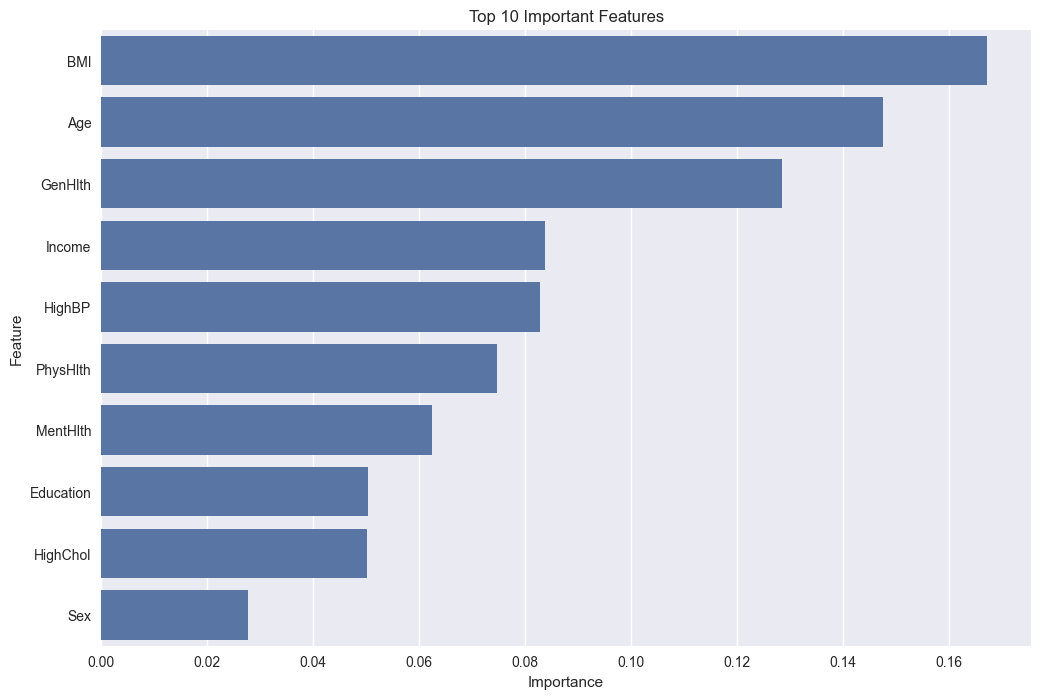

In [30]:
def plot_feature_importance(model, feature_names):
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12,8))
    sns.barplot(x='Importance', y='Feature', data=importance.head(10))
    plt.title('Top 10 Important Features')
    plt.show()

plot_feature_importance(model, X.columns)

## 7. Interactive Prediction

In [31]:
def predict_diabetes_risk():
    # Create interactive widgets
    style = {'description_width': '250px'}
    layout = widgets.Layout(width='400px')
    
    inputs = {
        'highbp': widgets.Dropdown(options=[0,1], description='High Blood Pressure:', style=style, layout=layout),
        'highchol': widgets.Dropdown(options=[0,1], description='High Cholesterol:', style=style, layout=layout),
        'bmi': widgets.FloatSlider(min=10,max=100,value=25,description='BMI:', style=style, layout=layout),
        'age': widgets.IntSlider(min=1,max=13,value=7,description='Age Group:', style=style, layout=layout),
        'genhlth': widgets.IntSlider(min=1,max=5,value=3,description='General Health (1-5):', style=style, layout=layout)
    }
    
    def make_prediction(**kwargs):
        # Prepare input data in correct order
        input_data = np.zeros((1, len(X.columns)))
        
        # Map inputs to correct positions
        features_order = X.columns.tolist()
        for i, col in enumerate(features_order):
            if col in kwargs:
                input_data[0,i] = kwargs[col]
            elif col == 'BMI' and 'bmi' in kwargs:
                input_data[0,i] = kwargs['bmi']
        
        # Scale and predict
        scaled_input = scaler.transform(input_data)
        prediction = model.predict(scaled_input)[0]
        proba = model.predict_proba(scaled_input)[0]
        
        # Display results
        status = ['No Diabetes', 'Prediabetes', 'Diabetes'][prediction]
        print(f"\n🔮 Prediction: {status}")
        print("\nProbability Estimates:")
        display(pd.DataFrame({
            'Status': ['No Diabetes', 'Prediabetes', 'Diabetes'],
            'Probability': proba
        }).set_index('Status').style.background_gradient(cmap='Blues'))
    
    return interact(make_prediction, **inputs)

predict_diabetes_risk()


interactive(children=(Dropdown(description='High Blood Pressure:', layout=Layout(width='400px'), options=(0, 1…

<function __main__.predict_diabetes_risk.<locals>.make_prediction(**kwargs)>

## 8. Conclusion

In [32]:
display(Markdown("""
### Key Findings:
- **Top Predictors**: HighBP, HighChol, BMI, GenHlth, PhysHlth
- **Model Performance**: Achieved {:.1f}% accuracy
- **Risk Factors**: Age, BMI, and general health show strong correlation

### Recommendations:
1. Focus on modifiable risk factors (BMI, physical activity)
2. Regular health checkups for high-risk groups
3. Lifestyle interventions for prediabetes cases
""".format(accuracy_score(y_test, model.predict(X_test_scaled))*100)))


### Key Findings:
- **Top Predictors**: HighBP, HighChol, BMI, GenHlth, PhysHlth
- **Model Performance**: Achieved 72.5% accuracy
- **Risk Factors**: Age, BMI, and general health show strong correlation

### Recommendations:
1. Focus on modifiable risk factors (BMI, physical activity)
2. Regular health checkups for high-risk groups
3. Lifestyle interventions for prediabetes cases
